In [1]:
import os
from itertools import product

import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
CSV_PATH = "/home/28i_mel@lab.graphicon.ru/mnt/dione/28i_mel/Linearity-results/"
get_base_line = lambda dataset, iter: f"{dataset}_resnet101+relu_PGD={iter}.csv"
sns.set_color_codes('deep')
sns.set_theme()

In [ ]:
activations = [
    "relu",
    "Frelu_elu",
    "Frelu_relu"
]
archs = [
    "resnet101",
    "vonenet50",
]
prunes = [ 
    {
        'percent': .0,
        'method': '',
    }, 
    {
        'percent': .1,
        'method': 'pls',
    },
    {
        'percent': .1,
        'method': 'hsic',
    },
    {
        'percent': .1,
        'method': 'l1',
    },
    {
        'percent': .1,
        'method': 'l2',
    }
]
cayley = [
    
    False,
    True,
]
cayley_pool = [
    True,
    False
]
cayley_pair = [
    
    False,
    True,
]
gradnorm = [
    
    False,
    True,
]
resizers = [
    True,
    False
]
quantize = [
    True,
    False
]

datasets = ["KonIQ-10k", "NIPS"]

In [4]:
available_results = os.listdir(CSV_PATH)

In [7]:
class Scores:
    def __init__(self, **kwargs):
        self.nips_df, self.koniq_df = kwargs.get("nips_df", None), kwargs.get("koniq_df", None)
        self.iters = kwargs.get("iters", 1)
    def fit(self, col):
        if self.nips_df is not None:
            # self.scaler_nips = MinMaxScaler()
            # self.scaler_nips.fit(self.nips_df[col].to_numpy().reshape(-1,1))
            self.nips_min = self.nips_df[col].min()
            self.nips_max = self.nips_df[col].max()
        if self.koniq_df is not None:
            # self.scaler_koniq = MinMaxScaler()
            # self.scaler_koniq.fit(self.koniq_df[col].to_numpy().reshape(-1,1))
            self.koniq_min = self.koniq_df[col].min()
            self.koniq_max = self.koniq_df[col].max()


    def scale(self, clear_val, attacked_val, dataset):
        if dataset=='NIPS':
            # scaled_clear_val = self.scaler_nips.transform(clear_val.reshape(-1,1))
            # scaled_attacked_val = self.scaler_nips.transform(attacked_val.reshape(-1,1))
            scaled_clear_val = ((clear_val - self.nips_min)/(self.nips_max - self.nips_min))
            scaled_attacked_val = ((attacked_val - self.nips_min)/(self.nips_max - self.nips_min))
        elif dataset=='KonIQ-10k':
            # scaled_clear_val = self.scaler_koniq.transform(clear_val.reshape(-1, 1))
            # scaled_attacked_val = self.scaler_koniq.transform(attacked_val.reshape(-1,1))
            scaled_clear_val = ((clear_val - self.koniq_min)/(self.koniq_max - self.koniq_min))
            scaled_attacked_val = ((attacked_val - self.koniq_min)/(self.koniq_max - self.koniq_min))
        return scaled_clear_val, scaled_attacked_val
    
    def get_abs_gain(self, clear_val, attacked_val, dataset='NIPS'):
        if isinstance(clear_val, pd.DataFrame) or isinstance(clear_val, pd.Series):
            clear_val = clear_val.to_numpy()
        if isinstance(attacked_val, pd.DataFrame) or isinstance(attacked_val, pd.Series):
            attacked_val = attacked_val.to_numpy()
        
        scaled_clear_val, scaled_attacked_val = self.scale(clear_val, attacked_val, dataset)
        # print(scaled_clear_val.min(), scaled_clear_val.max())
        # print(scaled_attacked_val, scaled_clear_val)
        return (scaled_attacked_val - scaled_clear_val).mean()

    def get_r_score(self, clear_val, attacked_val, dataset='NIPS'):
        if isinstance(clear_val, pd.DataFrame) or isinstance(clear_val, pd.Series):
            clear_val = clear_val.to_numpy()
        if isinstance(attacked_val, pd.DataFrame) or isinstance(attacked_val, pd.Series):
            attacked_val = attacked_val.to_numpy()
        scaled_clear_val, scaled_attacked_val = self.scale(clear_val, attacked_val, dataset)
        beta1 = max(scaled_attacked_val)
        beta0 = min(scaled_clear_val)
        # print(min(scaled_attacked_val), max(scaled_attacked_val), min(scaled_clear_val), max(scaled_clear_val))
        return np.mean(
            np.log10(
                np.maximum(beta1-scaled_attacked_val, scaled_clear_val-beta0)/np.abs(scaled_attacked_val-scaled_clear_val)
                )
            )

In [44]:
def get_metrics(activation, gr, clp, prune, prune_type):
    try:
        path = '/home/28i_mel@lab.graphicon.ru/mnt/dione/28i_mel/Linearity-ckpt'
        clp_status = '-clp=True' if clp else ''
        gr_status = '-gr=True' if gr else ''
        prune_status = f'+prune={prune}{prune_type}_lr=1e-06_e=5' if prune >0 else ''
        form = f'/activation={activation}-Linearity-resnet101-bs=8-loss=norm-in-norm-p=1.0-q=2.0-detach-False-KonIQ-10k-res=True-498x664{clp_status}{gr_status}{prune_status}'
        ckpt = torch.load(path+form)
        srcc = ckpt['SROCC']
        plcc = ckpt['PLCC']
        return srcc, plcc
    except:
        return None, None


In [49]:
def draw_plot(iterations=1, ax_rows=10, ax_cols=2, figsize=(14,50), wsapce=0.5, hspace=0.3, area=None):
    epsilons = [ 2, 4, 6, 8, 10 ]
    attack_type = "PGD"

    baseline_df_nips = pd.read_csv(os.path.join(CSV_PATH, get_base_line('NIPS', iterations)))
    baseline_df_koniq = pd.read_csv(os.path.join(CSV_PATH, get_base_line('KonIQ-10k', iterations)))
    scores = Scores(nips_df=baseline_df_nips, koniq_df=baseline_df_koniq)
    scores.fit(col='clear_val')

    baseLine = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
    for i, df in enumerate((baseline_df_koniq, baseline_df_nips)):
        for eps in epsilons:
            baseLine.loc[len(baseLine)] = {
                                        'eps': f"{eps}/255",
                                        'abs_gain': 
                                            scores.get_abs_gain(df['clear_val'], 
                                                                df[f'attacked_val_eps={eps}'],
                                                                dataset=datasets[i]),
                                        'r_score': 
                                            scores.get_r_score(df['clear_val'], 
                                                            df[f'attacked_val_eps={eps}'], 
                                                            dataset=datasets[i]),
                                        'dataset': datasets[i]
                                        }

    fig, axis = plt.subplots(ax_rows, ax_cols, figsize=figsize, sharey=False)
    plt.subplots_adjust(wspace=wsapce, hspace=hspace)
    # axis = axis.flatten()
    plot_idx = 0

    arch_title = None

    for (
        # dataset,
        is_cayley, 
        is_cayley_pool, 
        is_cayley_pair,
        is_gradnorm_regularization,
        prune,
        arch,
        activation,
        quant,
        is_resize,
        ) in product(
                        # datasets,
                        cayley, 
                        cayley_pool, 
                        cayley_pair, 
                        gradnorm,
                        prunes,
                        archs,
                        activations,
                        quantize,
                        resizers,
                        ):
        data = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
        for dataset in datasets:
            cl = f'+cayley' if is_cayley else ''
            clp = f'+cayley_pool' if is_cayley_pool else ''
            cp = f'+cayley_pair' if is_cayley_pair else ''
            gr = f'+gr' if is_gradnorm_regularization else ''
            qn = f'+quantize16' if quant else ''
            resize = f'+resize=498x664' if is_resize else ''
            prune_status = f"+{prune['percent']}_{prune['method']}" if prune['percent'] else ''
            arch_status = f'{arch}{cl}{clp}{cp}{gr}{qn}{prune_status}+{activation}'
            path = "{}_{}_{}={}{}.csv".format(
                                            dataset,
                                            arch_status,
                                            attack_type,
                                            iterations,
                                            resize
                                            )
            
            if path not in available_results:
                break
            
            path = os.path.join(CSV_PATH, path)
            df = pd.read_csv(path, index_col=False)
            
            arch_title = f"{arch_status}{resize} {attack_type}-{iterations}"
            for eps in epsilons:
                data.loc[len(data)] = {
                        'eps': f'{int(eps)}/255',
                        'abs_gain': scores.get_abs_gain(df['clear_val'], 
                                                        df[f'attacked_val_eps={eps}'],
                                                        dataset=dataset),
                        'r_score': scores.get_r_score(df['clear_val'], 
                                                    df[f'attacked_val_eps={eps}'], 
                                                    dataset=dataset),
                        'dataset': dataset,
                }
            srcc, plcc = get_metrics(activation, gr, clp, prune['percent'], prune['method'])
            area.loc[len(area)] = {
                "arch": arch,
                "activation": activation,
                "cayley": is_cayley_pool,
                "prune": f"{prune['percent']}-{prune['method']}",
                "NT": is_gradnorm_regularization,
                "pgd": iterations,
                "dataset": dataset,
                "SROCC": srcc,
                "PLCC": plcc,
                "area": np.trapezoid(y=data.sort_values(by='eps')['abs_gain'].to_numpy(), dx=8/255)
            }

        
        if len(data) > 0:
            sns.lineplot(data=baseLine, x='eps', y='abs_gain', linewidth=1.5, linestyle='--',
                         hue='dataset', ax=axis[plot_idx][0]
                        )
            sns.lineplot(data=data, x='eps', y='abs_gain', 
                         hue="dataset", ax=axis[plot_idx][0])
            
            sns.lineplot(data=baseLine, x='eps', y='r_score', linewidth=1.5, linestyle='--',
                        legend='full', hue='dataset', ax=axis[plot_idx][1]
                        )
            sns.lineplot(data=data, x='eps', y='r_score',
                        legend="full", hue="dataset", ax=axis[plot_idx][1])
            axis[plot_idx][0].set_ylabel('AbsGain')
            axis[plot_idx][0].set_title(arch_title)
            # axis[plot_idx][0].legend(title='', loc='lower left', labels=['baseline', 'model'])
            
            # axis[plot_idx][0].legend_.remove()
            axis[plot_idx][1].set_ylabel('R-Score')
            axis[plot_idx][1].set_title(arch_title)
            plot_idx += 1

    plt.show()

In [50]:
area = pd.DataFrame(columns=['arch', 'activation', 'cayley', 'pruning', 'NT', 
                             'pgd', 'dataset', 
                             'SROCC', 'PLCC', 'area'])

/tmp/ipykernel_2303532/610682880.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path+form)
/tmp/ipykernel_2303532/610682880.py:8: FutureWarning: You a

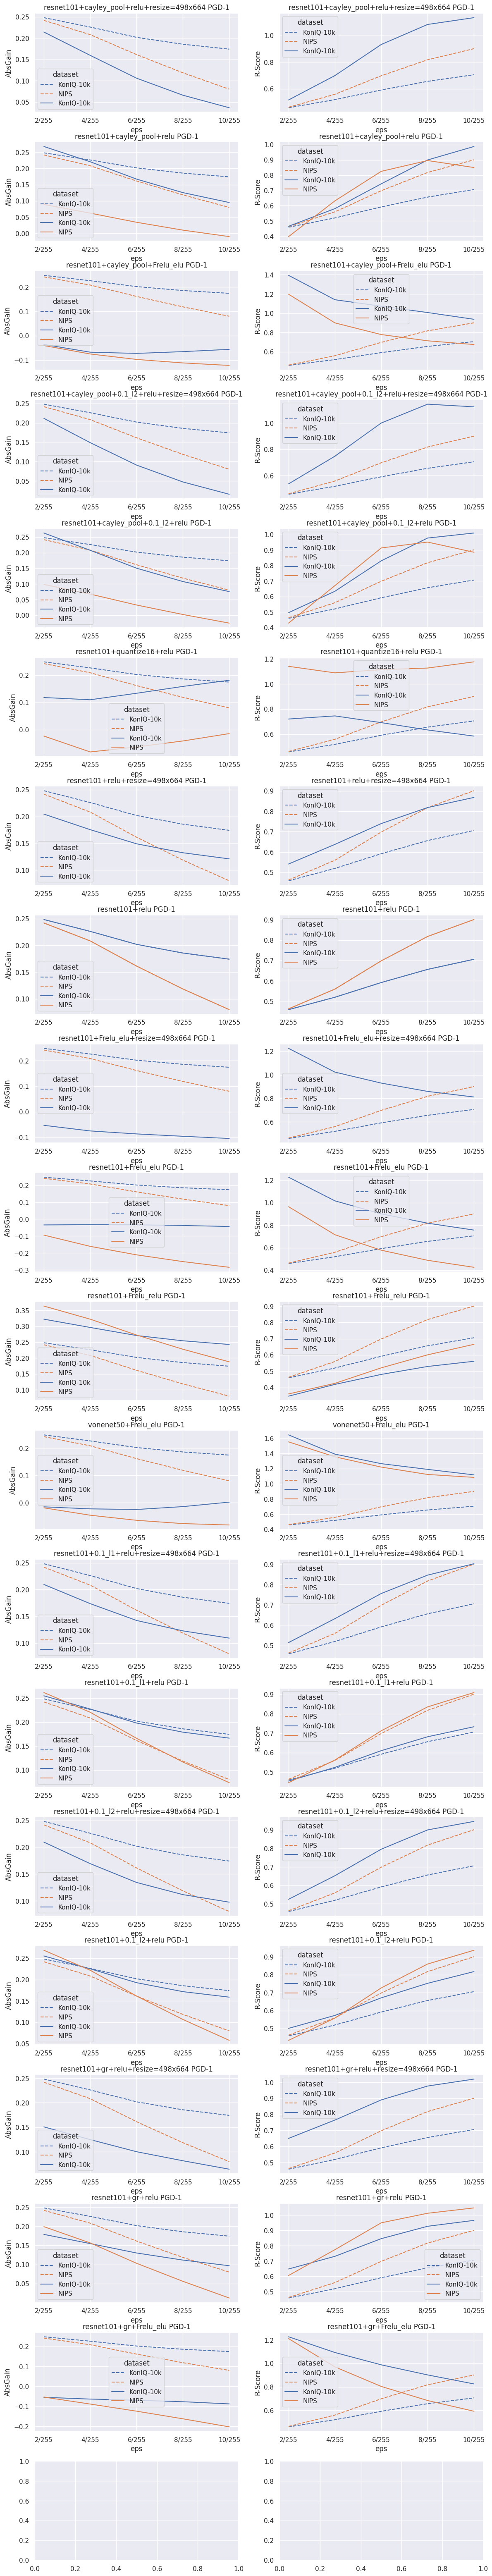

In [51]:
draw_plot(iterations=1, ax_rows=20, ax_cols=2, figsize=(14,80), wsapce=0.2, hspace=0.3, area=area)

In [52]:
area

arch  activation  cayley  pruning     NT  pgd    dataset     SROCC  \
0   resnet101        relu    True      NaN  False    1  KonIQ-10k  0.923064   
1   resnet101        relu    True      NaN  False    1  KonIQ-10k  0.923064   
2   resnet101        relu    True      NaN  False    1       NIPS  0.923064   
3   resnet101   Frelu_elu    True      NaN  False    1  KonIQ-10k  0.879596   
4   resnet101   Frelu_elu    True      NaN  False    1       NIPS  0.879596   
5   resnet101        relu    True      NaN  False    1  KonIQ-10k  0.922501   
6   resnet101        relu    True      NaN  False    1  KonIQ-10k  0.922501   
7   resnet101        relu    True      NaN  False    1       NIPS  0.922501   
8   resnet101        relu   False      NaN  False    1  KonIQ-10k  0.922532   
9   resnet101        relu   False      NaN  False    1       NIPS  0.922532   
10  resnet101        relu   False      NaN  False    1  KonIQ-10k  0.922532   
11  resnet101        relu   False      NaN  False    1  KonIQ-10k  0.922532   
12  resnet101        relu   False      NaN  False    1       NIPS  0.922532   
13  resnet101   Frelu_elu   False      NaN  False    1  KonIQ-10k  0.891110   
14  resnet101   Frelu_elu   False      NaN  False    1  KonIQ-10k  0.891110   
15  resnet101   Frelu_elu   False      NaN  False    1       NIPS  0.891110   
16  resnet101  Frelu_relu   False      NaN  False    1  KonIQ-10k       NaN   
17  resnet101  Frelu_relu   False      NaN  False    1       NIPS       NaN   
18  vonenet50   Frelu_elu   False      NaN  False    1  KonIQ-10k  0.891110   
19  vonenet50   Frelu_elu   False      NaN  False    1       NIPS  0.891110   
20  resnet101        relu   False      NaN  False    1  KonIQ-10k       NaN   
21  resnet101        relu   False      NaN  False    1  KonIQ-10k       NaN   
22  resnet101        relu   False      NaN  False    1       NIPS       NaN   
23  resnet101        relu   False      NaN  False    1  KonIQ-10k       NaN   
24  resnet101        relu   False      NaN  False    1  KonIQ-10k       NaN   
25  resnet101        relu   False      NaN  False    1       NIPS       NaN   
26  resnet101        relu   False      NaN   True    1  KonIQ-10k  0.904410   
27  resnet101        relu   False      NaN   True    1  KonIQ-10k  0.904410   
28  resnet101        relu   False      NaN   True    1       NIPS  0.904410   
29  resnet101   Frelu_elu   False      NaN   True    1  KonIQ-10k  0.870385   
30  resnet101   Frelu_elu   False      NaN   True    1       NIPS  0.870385   

        PLCC      area  
0   0.935632  0.016656  
1   0.935632  0.024029  
2   0.935632  0.031659  
3   0.888622 -0.007464  
4   0.888622 -0.020800  
5   0.936573  0.015142  
6   0.936573  0.022358  
7   0.936573  0.029511  
8   0.934035  0.016638  
9   0.934035  0.012783  
10  0.934035  0.020568  
11  0.934035  0.026858  
12  0.934035  0.053319  
13  0.897885 -0.009948  
14  0.897885 -0.004414  
15  0.897885 -0.032522  
16       NaN  0.035700  
17       NaN  0.079226  
18  0.897885 -0.002165  
19  0.897885 -0.010215  
20       NaN  0.020125  
21       NaN  0.026724  
22       NaN  0.053970  
23       NaN  0.019375  
24       NaN  0.026308  
25       NaN  0.052944  
26  0.920752  0.014088  
27  0.920752  0.017812  
28  0.920752  0.035204  
29  0.879230 -0.008472  
30  0.879230 -0.026934

In [ ]:
draw_plot(iterations=3, ax_rows=20, ax_cols=2, figsize=(14,80), wsapce=0.2, hspace=0.3)

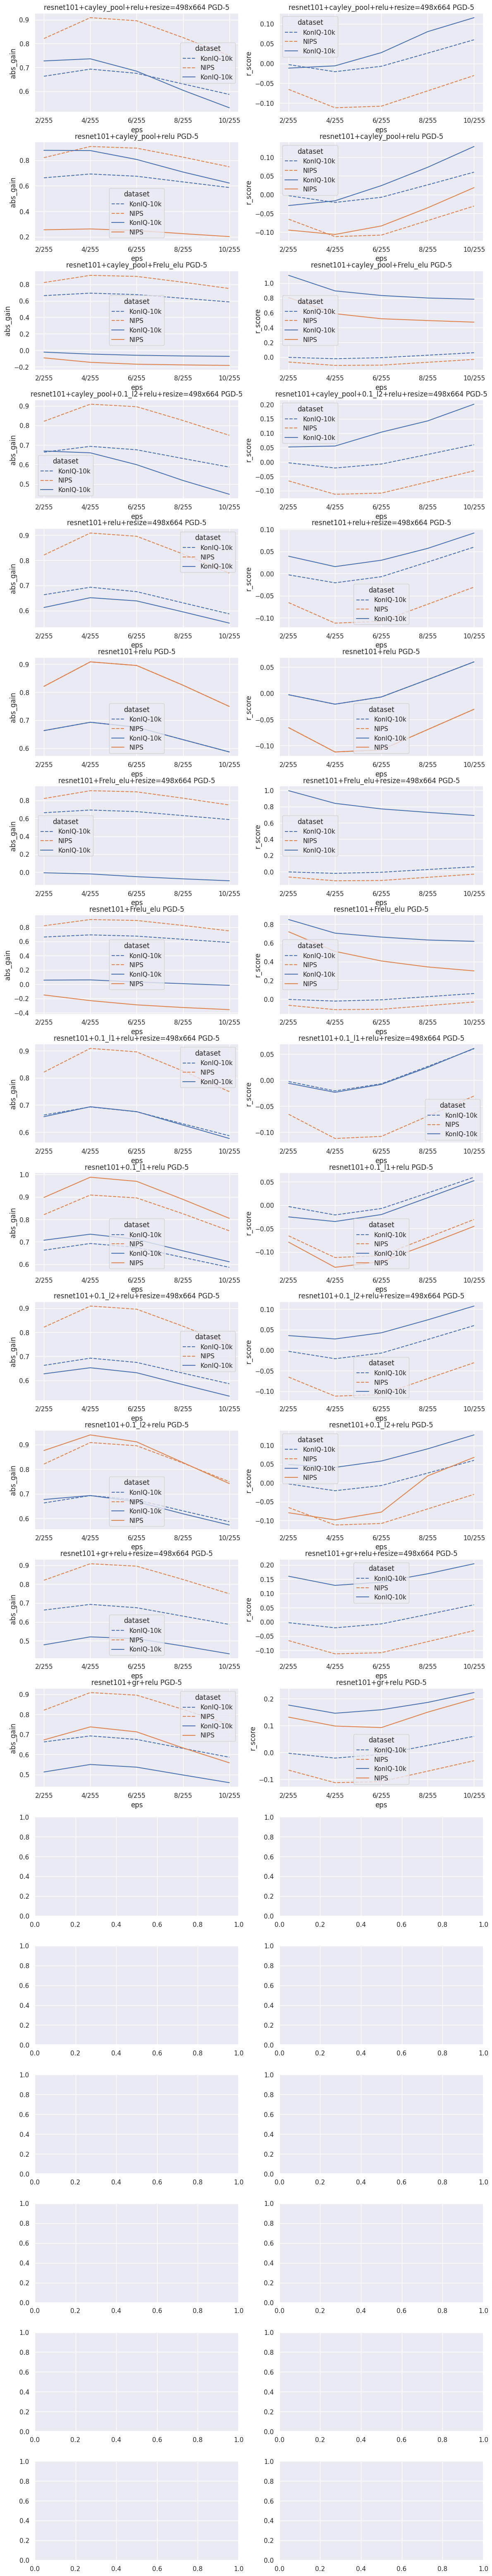

In [9]:
draw_plot(iterations=5, ax_rows=20, ax_cols=2, figsize=(14,80), wsapce=0.2, hspace=0.3)

In [25]:
area

arch  activation  cayley  pruning     NT  pgd      area
0   resnet101        relu    True      NaN  False    1  0.016656
1   resnet101        relu    True      NaN  False    1  0.024029
2   resnet101        relu    True      NaN  False    1  0.031659
3   resnet101   Frelu_elu    True      NaN  False    1 -0.007464
4   resnet101   Frelu_elu    True      NaN  False    1 -0.020800
5   resnet101        relu    True      NaN  False    1  0.015142
6   resnet101        relu    True      NaN  False    1  0.022358
7   resnet101        relu    True      NaN  False    1  0.029511
8   resnet101        relu   False      NaN  False    1  0.016638
9   resnet101        relu   False      NaN  False    1  0.012783
10  resnet101        relu   False      NaN  False    1  0.020568
11  resnet101        relu   False      NaN  False    1  0.026858
12  resnet101        relu   False      NaN  False    1  0.053319
13  resnet101   Frelu_elu   False      NaN  False    1 -0.009948
14  resnet101   Frelu_elu   False      NaN  False    1 -0.004414
15  resnet101   Frelu_elu   False      NaN  False    1 -0.032522
16  resnet101  Frelu_relu   False      NaN  False    1  0.035700
17  resnet101  Frelu_relu   False      NaN  False    1  0.079226
18  vonenet50   Frelu_elu   False      NaN  False    1 -0.002165
19  vonenet50   Frelu_elu   False      NaN  False    1 -0.010215
20  resnet101        relu   False      NaN  False    1  0.020125
21  resnet101        relu   False      NaN  False    1  0.026724
22  resnet101        relu   False      NaN  False    1  0.053970
23  resnet101        relu   False      NaN  False    1  0.019375
24  resnet101        relu   False      NaN  False    1  0.026308
25  resnet101        relu   False      NaN  False    1  0.052944
26  resnet101        relu   False      NaN   True    1  0.014088
27  resnet101        relu   False      NaN   True    1  0.017812
28  resnet101        relu   False      NaN   True    1  0.035204
29  resnet101   Frelu_elu   False      NaN   True    1 -0.008472
30  resnet101   Frelu_elu   False      NaN   True    1 -0.026934

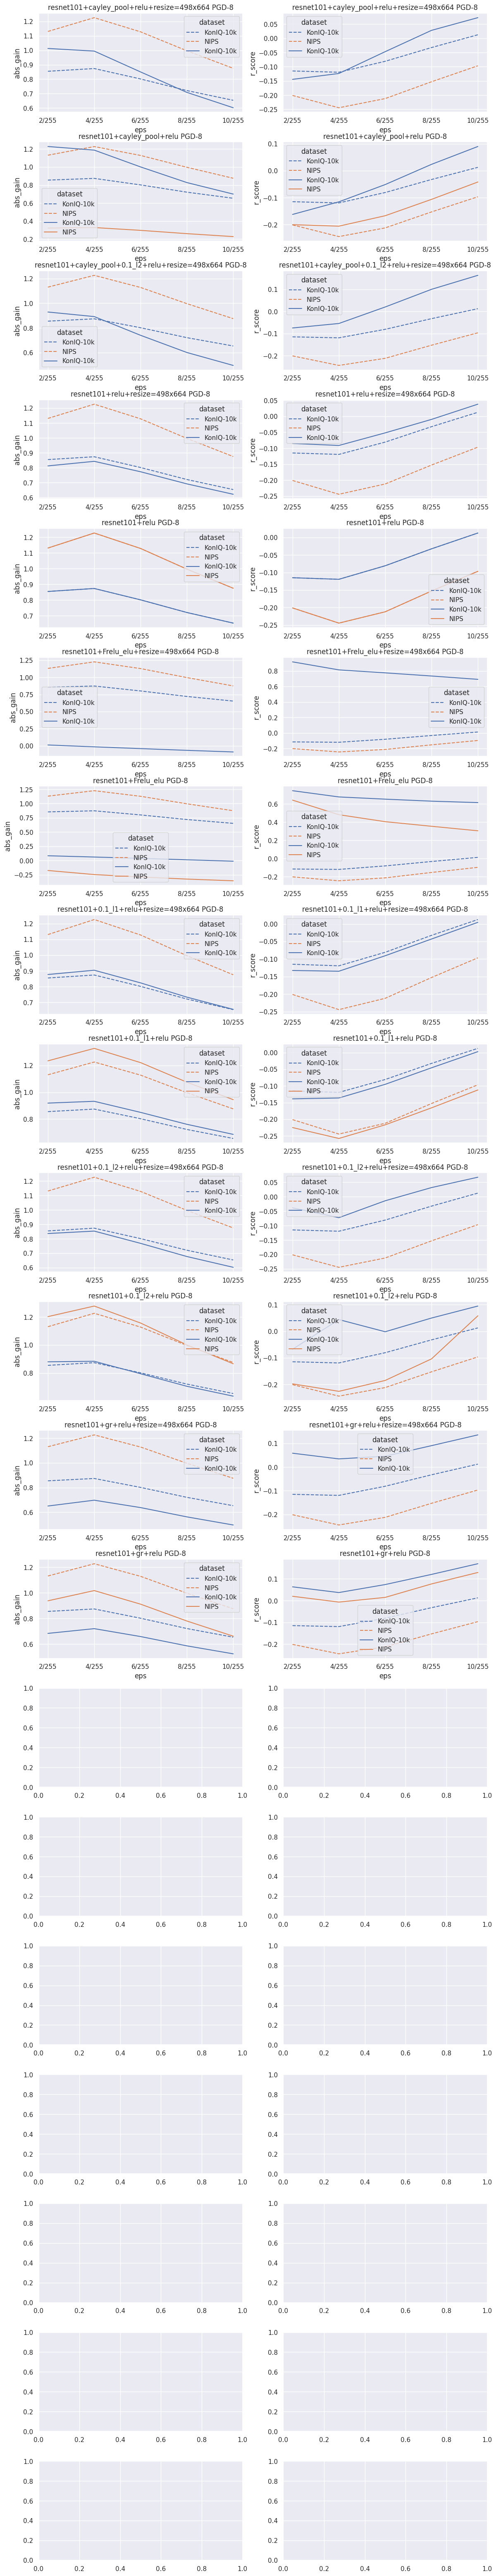

In [10]:
draw_plot(iterations=8, ax_rows=20, ax_cols=2, figsize=(14,80), wsapce=0.2, hspace=0.3)

<Axes: xlabel='eps', ylabel='r_score'>

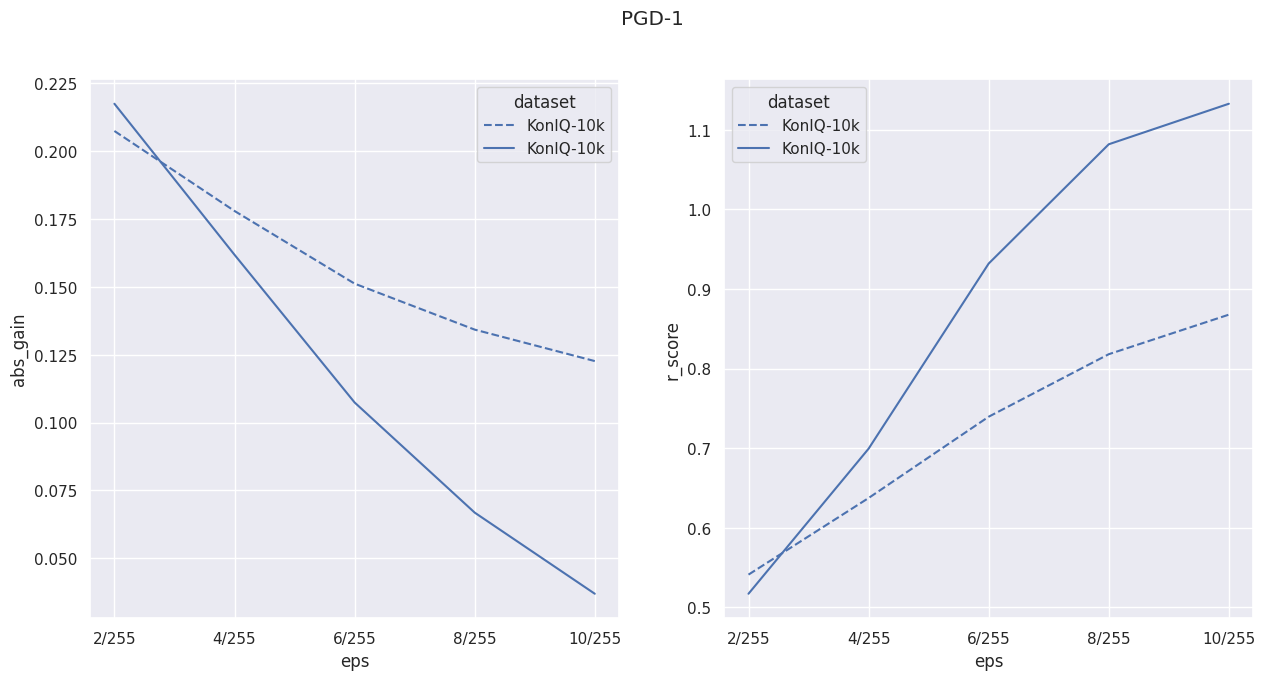

In [162]:
itr = 1
epsilons = [2, 4, 6, 8, 10]
path_resize = f'KonIQ-10k_resnet101+relu_PGD={itr}+resize=498x664.csv'
path_resize_clp = f'KonIQ-10k_resnet101+cayley_pool+relu_PGD={itr}+resize=498x664.csv'

baseline_df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

baseLine = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
for eps in epsilons:
    baseLine.loc[len(baseLine)] = {
                                'eps': f"{eps}/255",
                                'abs_gain': 
                                    scores.get_abs_gain(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'],
                                                        dataset='KonIQ-10k'),
                                'r_score': 
                                    scores.get_r_score(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'], 
                                                        dataset='KonIQ-10k'),
                                'dataset': 'KonIQ-10k'
                                }

modif = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize_clp))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

for eps in epsilons:
    modif.loc[len(modif)] = {
                            'eps': f"{eps}/255",
                            'abs_gain': 
                                scores.get_abs_gain(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'],
                                                    dataset='KonIQ-10k'),
                            'r_score': 
                                scores.get_r_score(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'], 
                                                    dataset='KonIQ-10k'),
                            'dataset': 'KonIQ-10k'
                            }
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle(f'PGD-{itr}')
sns.lineplot(data=baseLine, x='eps', y='abs_gain', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[0])
sns.lineplot(data=modif, x='eps', y='abs_gain', 
            legend="full", hue="dataset", ax=ax[0])

sns.lineplot(data=baseLine, x='eps', y='r_score', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[1])
sns.lineplot(data=modif, x='eps', y='r_score', 
            legend="full", hue="dataset", ax=ax[1])

<Axes: xlabel='eps', ylabel='r_score'>

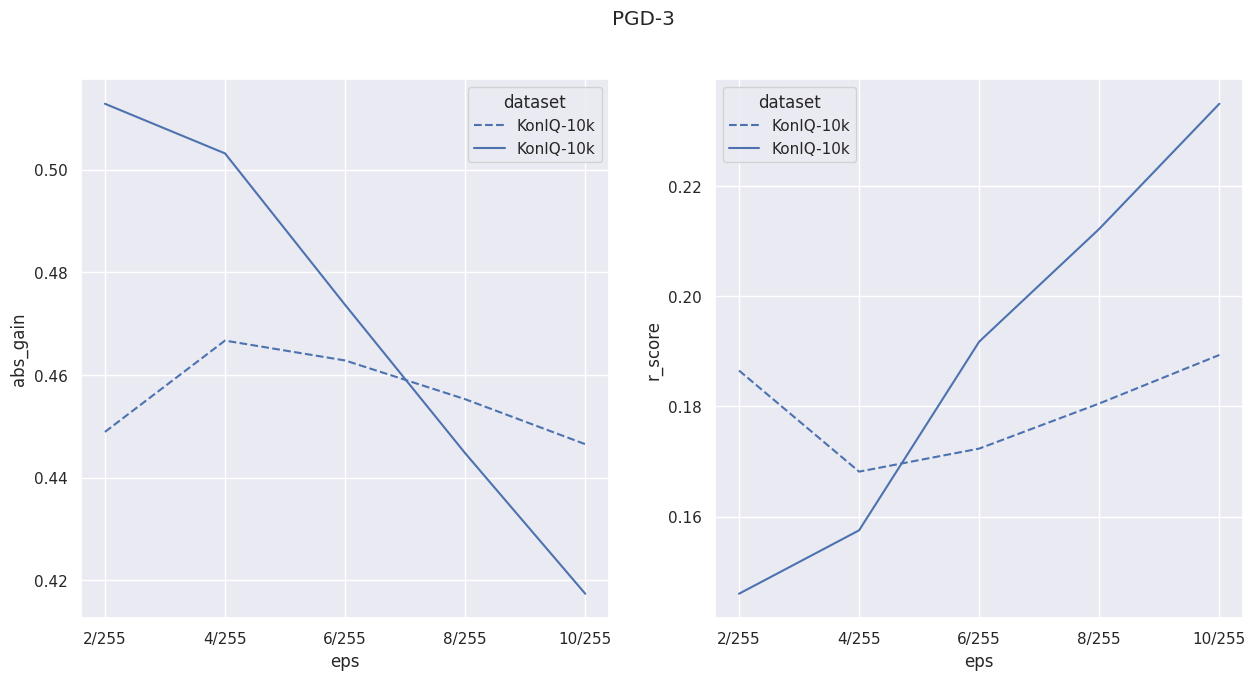

In [163]:
itr = 3
epsilons = [2, 4, 6, 8, 10]
path_resize = f'KonIQ-10k_resnet101+relu_PGD={itr}+resize=498x664.csv'
path_resize_clp = f'KonIQ-10k_resnet101+cayley_pool+relu_PGD={itr}+resize=498x664.csv'

baseline_df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

baseLine = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
for eps in epsilons:
    baseLine.loc[len(baseLine)] = {
                                'eps': f"{eps}/255",
                                'abs_gain': 
                                    scores.get_abs_gain(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'],
                                                        dataset='KonIQ-10k'),
                                'r_score': 
                                    scores.get_r_score(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'], 
                                                        dataset='KonIQ-10k'),
                                'dataset': 'KonIQ-10k'
                                }

modif = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize_clp))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

for eps in epsilons:
    modif.loc[len(modif)] = {
                            'eps': f"{eps}/255",
                            'abs_gain': 
                                scores.get_abs_gain(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'],
                                                    dataset='KonIQ-10k'),
                            'r_score': 
                                scores.get_r_score(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'], 
                                                    dataset='KonIQ-10k'),
                            'dataset': 'KonIQ-10k'
                            }
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle(f'PGD-{itr}')
sns.lineplot(data=baseLine, x='eps', y='abs_gain', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[0])
sns.lineplot(data=modif, x='eps', y='abs_gain', 
            legend="full", hue="dataset", ax=ax[0])

sns.lineplot(data=baseLine, x='eps', y='r_score', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[1])
sns.lineplot(data=modif, x='eps', y='r_score', 
            legend="full", hue="dataset", ax=ax[1])

<Axes: xlabel='eps', ylabel='r_score'>

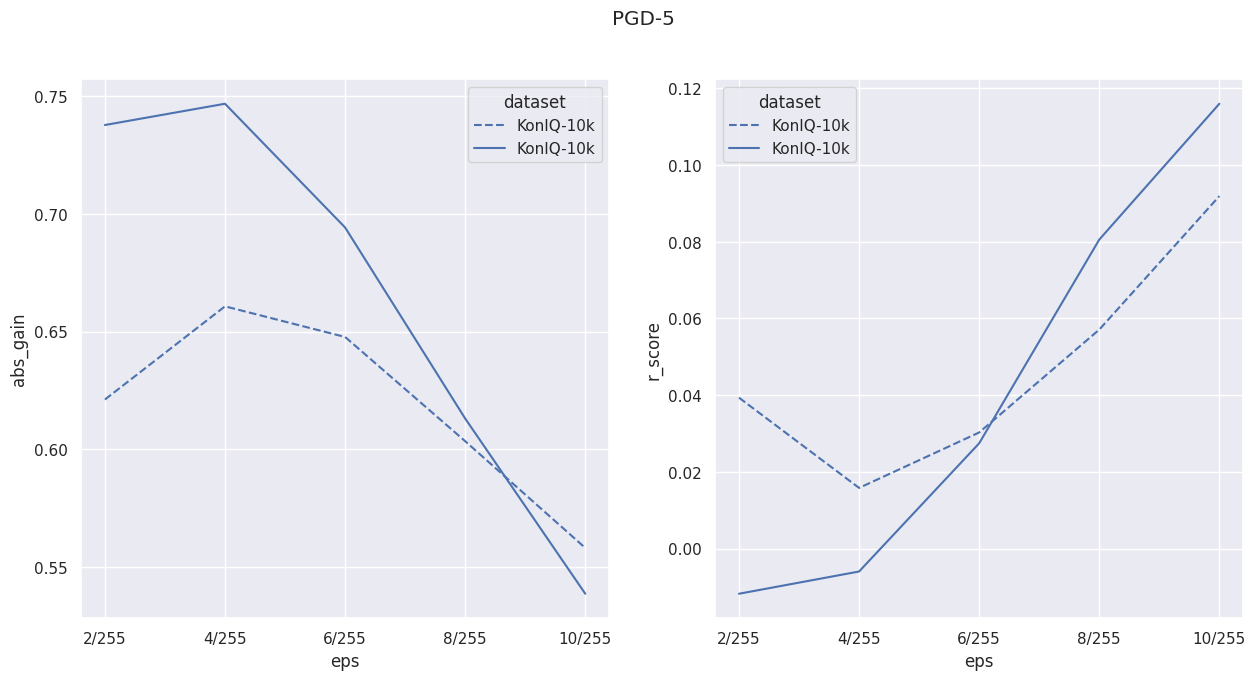

In [164]:
itr = 5
epsilons = [2, 4, 6, 8, 10]
path_resize = f'KonIQ-10k_resnet101+relu_PGD={itr}+resize=498x664.csv'
path_resize_clp = f'KonIQ-10k_resnet101+cayley_pool+relu_PGD={itr}+resize=498x664.csv'

baseline_df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

baseLine = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
for eps in epsilons:
    baseLine.loc[len(baseLine)] = {
                                'eps': f"{eps}/255",
                                'abs_gain': 
                                    scores.get_abs_gain(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'],
                                                        dataset='KonIQ-10k'),
                                'r_score': 
                                    scores.get_r_score(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'], 
                                                        dataset='KonIQ-10k'),
                                'dataset': 'KonIQ-10k'
                                }

modif = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize_clp))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

for eps in epsilons:
    modif.loc[len(modif)] = {
                            'eps': f"{eps}/255",
                            'abs_gain': 
                                scores.get_abs_gain(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'],
                                                    dataset='KonIQ-10k'),
                            'r_score': 
                                scores.get_r_score(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'], 
                                                    dataset='KonIQ-10k'),
                            'dataset': 'KonIQ-10k'
                            }
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle(f'PGD-{itr}')
sns.lineplot(data=baseLine, x='eps', y='abs_gain', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[0])
sns.lineplot(data=modif, x='eps', y='abs_gain', 
            legend="full", hue="dataset", ax=ax[0])

sns.lineplot(data=baseLine, x='eps', y='r_score', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[1])
sns.lineplot(data=modif, x='eps', y='r_score', 
            legend="full", hue="dataset", ax=ax[1])

<Axes: xlabel='eps', ylabel='r_score'>

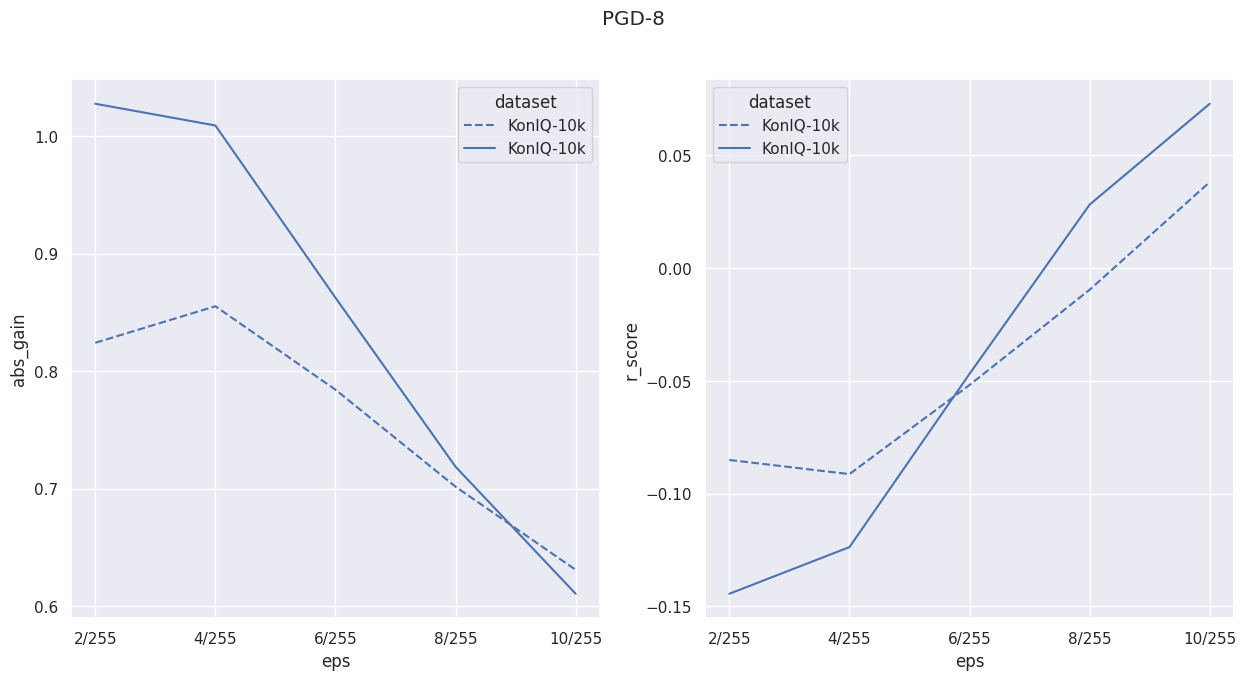

In [165]:
itr = 8
epsilons = [2, 4, 6, 8, 10]
path_resize = f'KonIQ-10k_resnet101+relu_PGD={itr}+resize=498x664.csv'
path_resize_clp = f'KonIQ-10k_resnet101+cayley_pool+relu_PGD={itr}+resize=498x664.csv'

baseline_df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

baseLine = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
for eps in epsilons:
    baseLine.loc[len(baseLine)] = {
                                'eps': f"{eps}/255",
                                'abs_gain': 
                                    scores.get_abs_gain(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'],
                                                        dataset='KonIQ-10k'),
                                'r_score': 
                                    scores.get_r_score(baseline_df_koniq['clear_val'], 
                                                        baseline_df_koniq[f'attacked_val_eps={eps}'], 
                                                        dataset='KonIQ-10k'),
                                'dataset': 'KonIQ-10k'
                                }

modif = pd.DataFrame(columns=['eps', 'abs_gain', 'r_score', 'dataset'])
df_koniq = pd.read_csv(os.path.join(CSV_PATH, path_resize_clp))
scores = Scores(nips_df=None, koniq_df=baseline_df_koniq)
scores.fit(col='clear_val')

for eps in epsilons:
    modif.loc[len(modif)] = {
                            'eps': f"{eps}/255",
                            'abs_gain': 
                                scores.get_abs_gain(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'],
                                                    dataset='KonIQ-10k'),
                            'r_score': 
                                scores.get_r_score(df_koniq['clear_val'], 
                                                    df_koniq[f'attacked_val_eps={eps}'], 
                                                    dataset='KonIQ-10k'),
                            'dataset': 'KonIQ-10k'
                            }
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

fig.suptitle(f'PGD-{itr}')
sns.lineplot(data=baseLine, x='eps', y='abs_gain', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[0])
sns.lineplot(data=modif, x='eps', y='abs_gain', 
            legend="full", hue="dataset", ax=ax[0])

sns.lineplot(data=baseLine, x='eps', y='r_score', linewidth=1.5, linestyle='--',
            legend='full', hue='dataset', ax=ax[1])
sns.lineplot(data=modif, x='eps', y='r_score', 
            legend="full", hue="dataset", ax=ax[1])

In [ ]:
x = [2, 4, 6, 8, 10]
grp = set(group_wd+group_activation+group_pruning+group_special)
iters = [1, 3, 5, 8]

df_pgd_small_eps = pd.DataFrame(columns=['architecture', 'activation', 'SROCC','result_iter=1','result_iter=3','result_iter=5', 'result_iter=8'])

for arch, activ in grp:
    y_axises = []
    for it in iters:
        y_axis = data[(data["arch"]==arch)&(data["iterations"]==it)&(data["activation"]==activ)]\
            .loc[:,f"eps {epsilons[0]}": f"eps {epsilons[len(x)-1]}"].values.tolist()[0]
        y_axises.append(y_axis)
    srocc = data[(data["arch"]==arch)&(data["iterations"]==iters[0])&(data["activation"]==activ)].loc[:,"SROCC"].values.tolist()[0]
    df_pgd_small_eps.loc[len(df_pgd_small_eps)] = {
                                'architecture': arch, 
                                'activation': activ,
                                'SROCC': float(srocc),
                                'result_iter=1': (np.trapezoid(y_axises[0], x)),
                                'result_iter=3': (np.trapezoid(y_axises[1], x)),
                                'result_iter=5': (np.trapezoid(y_axises[2], x)),
                                'result_iter=8': (np.trapezoid(y_axises[3], x))
                                }
baseline_res_iter1 = df_pgd_small_eps[(df_pgd_small_eps['architecture']==baseline[0][0])&(df_pgd_small_eps['activation']==baseline[0][1])]['result_iter=1'].values[0]
baseline_res_iter3 = df_pgd_small_eps[(df_pgd_small_eps['architecture']==baseline[0][0])&(df_pgd_small_eps['activation']==baseline[0][1])]['result_iter=3'].values[0]
baseline_res_iter5 = df_pgd_small_eps[(df_pgd_small_eps['architecture']==baseline[0][0])&(df_pgd_small_eps['activation']==baseline[0][1])]['result_iter=5'].values[0]
baseline_res_iter8 = df_pgd_small_eps[(df_pgd_small_eps['architecture']==baseline[0][0])&(df_pgd_small_eps['activation']==baseline[0][1])]['result_iter=8'].values[0]
# print(baseline_res_iter1)
# print( (baseline_res_iter1-df_pgd['result_iter=1'])/baseline_res_iter1)

df_pgd_small_eps['gain_iter=1'] = (baseline_res_iter1 - df_pgd_small_eps['result_iter=1'])/baseline_res_iter1 *100
df_pgd_small_eps['gain_iter=3'] = (baseline_res_iter3 - df_pgd_small_eps['result_iter=3'])/baseline_res_iter3 *100
df_pgd_small_eps['gain_iter=5'] = (baseline_res_iter5 - df_pgd_small_eps['result_iter=5'])/baseline_res_iter5 *100
df_pgd_small_eps['gain_iter=8'] = (baseline_res_iter8 - df_pgd_small_eps['result_iter=8'])/baseline_res_iter8 *100